# Beta / Kumaraswamy Oracle Consensus Algorithms

In [2]:
import numpy as np
from typing import List, Tuple
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mode
from itertools import compress

## Sample Data

In [3]:
def generate_beta_oracles(N_oracles, N_failing_oracles, a : float, b : float):
    oracles = [
        (np.random.beta(a, b), True)
        if i >= N_failing_oracles 
        else (np.random.uniform(0, 1), False)
        for i in range(N_oracles)
    ]

    np.random.shuffle(oracles)
    disjoint = tuple(map(list, zip(*oracles)))
    return disjoint

def generate_2d_beta_oracles(N_oracles, N_failing_oracles, a : Tuple[float], b : Tuple[float]):
    oracles = [
        (np.array([
            np.random.beta(a[0], b[0]),
            np.random.beta(a[1], b[1])
            ]), True)
        if i >= N_failing_oracles 
        else (np.array([
            np.random.uniform(0, 1),
            np.random.uniform(0, 1) 
            ]), False)
        for i in range(N_oracles)
    ]

    np.random.shuffle(oracles)
    # disjoint = tuple(map(list, zip(*oracles)))
    
    values, validity = zip(*oracles)

    return np.array(values), np.array(validity)

In [4]:
def kumaraswamy_mode(a : float, b : float) -> float:
    return ((a - 1) / (a*b - 1)) ** (1 / a)

def beta_mode(a : float, b:float) -> float:
    return (a - 1) / (a + b - 2)

#### Typical data

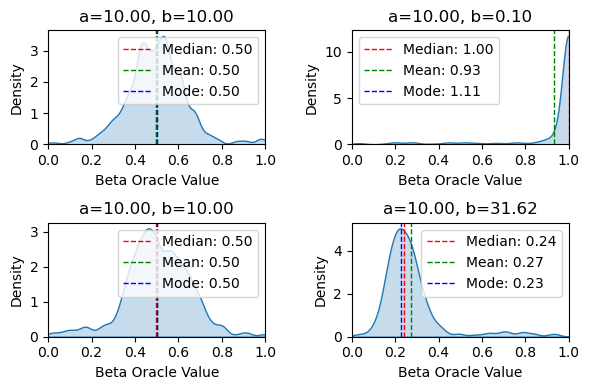

In [5]:
def plot_oracles_density(N_oracles, N_failing_oracles, a, b):
    # Generate oracles for each combination of true essence and true sigma
    oracles_sets = [
        generate_beta_oracles(N_oracles, N_failing_oracles, a[i], b[i])
        for i in range(len(a))
    ]

    # Set up the matplotlib figure with 4 subplots
    fig, axes = plt.subplots(2, 2, figsize=(6, 4))
    axes = axes.flatten()

    # Titles for each subplot
    titles = [f'a={a[i]:0.2f}, b={b[i]:0.2f}' for i in range(len(a))]


    # Plot each oracle set
    for i, (oracles, true_oracles) in enumerate(oracles_sets):
        oracle_values = np.array(oracles)
        sns.kdeplot(oracle_values, bw_adjust=0.5, fill=True, ax=axes[i])
        
        # Calculate statistics
        median_val = np.median(oracle_values)
        mean_val = np.mean(oracle_values)
        mode_val = beta_mode(a[i], b[i])

        # Add horizontal lines for median, mean, and mode
        axes[i].axvline(median_val, color='red', linestyle='--', linewidth=1, label=f'Median: {median_val:.2f}')
        axes[i].axvline(mean_val, color='green', linestyle='--', linewidth=1, label=f'Mean: {mean_val:.2f}')
        axes[i].axvline(mode_val, color='blue', linestyle='--', linewidth=1, label=f'Mode: {mode_val:.2f}')

        # Annotate the lines
        axes[i].legend()

        axes[i].set_xlim(0, 1)
        axes[i].set_title(titles[i])
        axes[i].set_xlabel('Beta Oracle Value')
        axes[i].set_ylabel('Density')
    plt.tight_layout()
    plt.show()

base_a = 10
a = np.array([base_a, base_a, base_a, base_a])
mirror = 1
b = np.array([base_a**mirror, base_a**-mirror, base_a, base_a**1.5])

plot_oracles_density(500, 60, a, b)


The median seems to be a good estimator for the mode.

### Samples for the Algorithm

In [6]:
N_oracles = 20
failing_percentage = 0.2
N_failing_oracles = round(N_oracles * failing_percentage)

In [7]:
a = 10

b_1d = 1
b_2d = [15, 30]

oracles, true_oracles = generate_beta_oracles(N_oracles, N_failing_oracles, a, a)
oracles_2d, true_oracles_2d = generate_2d_beta_oracles(
    N_oracles, N_failing_oracles, [a, a], [15, 15])

true_essence_1d = beta_mode(a, b_1d)
true_essence_2d = (beta_mode(a, b_2d[0]), beta_mode(a, b_2d[1]))

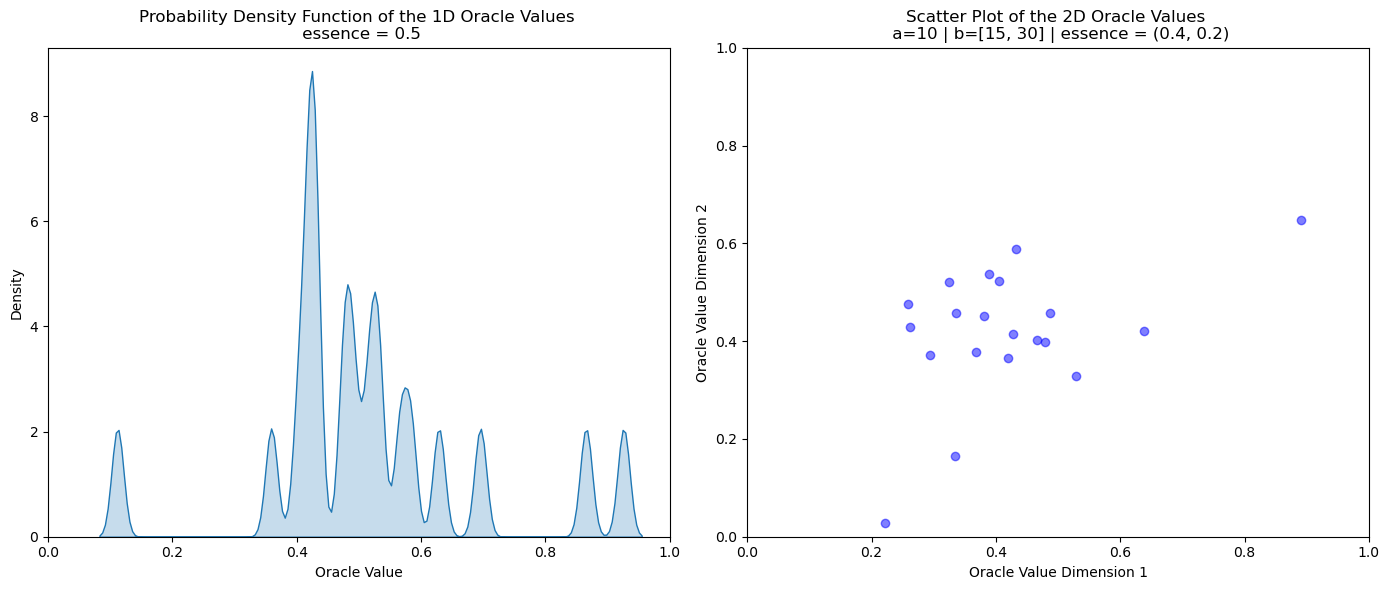

In [8]:
def plot():
    oracle_values = np.array(oracles)
    oracle_values_2d = oracles_2d
    
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
    sns.kdeplot(oracle_values, bw_adjust=0.1, fill=True, ax=axs[0])
    axs[0].set_xlim(0, 1)
    axs[0].set_title('Probability Density Function of the 1D Oracle Values \n essence = 0.5')
    axs[0].set_xlabel('Oracle Value')
    axs[0].set_ylabel('Density')
    
    axs[1].scatter(oracle_values_2d[:, 0], oracle_values_2d[:, 1], c='b', alpha=0.5)
    axs[1].set_xlim(0, 1)
    axs[1].set_ylim(0, 1)

    string_2d_essence = f'({true_essence_2d[0]:0.01f}, {true_essence_2d[1]:0.01f})'
    axs[1].set_title(f'Scatter Plot of the 2D Oracle Values \n a={a} | b={b_2d} | essence = {string_2d_essence}')
    axs[1].set_xlabel('Oracle Value Dimension 1')
    axs[1].set_ylabel('Oracle Value Dimension 2')
    
    plt.tight_layout()
    plt.show()

plot()

In [9]:
def to_wsad(x : float) -> float:
    return int(x * 1e6)

In [10]:
def reliability(std : float) -> float :
    return 1 - 2*std

def expected_reliability(arr : np.array) -> float :
    a = np.abs(arr - np.median(arr))
    b = np.mean(a)

    return reliability(b)

In [11]:
print(f"first pass reliability approximation : {expected_reliability(oracles):0.3f}")
print([to_wsad(x) for x in oracles])

first pass reliability approximation : 0.762
[513545, 430390, 111567, 532123, 421836, 525475, 583026, 628533, 566368, 401867, 413868, 925730, 491984, 423429, 695278, 359057, 481550, 474496, 865262, 429055]


In [12]:
print(f"first pass reliability approximation : {expected_reliability(oracles_2d):0.3f}")
for (x, y) in oracles_2d :
    print(f"array![{to_wsad(x)}, {to_wsad(y)}].span(), ") 

first pass reliability approximation : 0.807
array![258005, 475250].span(), 
array![294490, 371295].span(), 
array![335204, 457791].span(), 
array![486974, 456872].span(), 
array![890935, 648042].span(), 
array![333919, 164765].span(), 
array![431707, 589342].span(), 
array![637673, 420898].span(), 
array![262203, 429725].span(), 
array![388165, 538201].span(), 
array![479626, 397652].span(), 
array![404740, 523646].span(), 
array![419704, 365156].span(), 
array![426849, 415278].span(), 
array![221778, 27327].span(), 
array![324546, 521431].span(), 
array![528591, 328283].span(), 
array![465701, 401384].span(), 
array![368714, 377910].span(), 
array![381369, 452191].span(), 


## Benchmark
---

In [13]:
def rank_array(list : List[float], normalized=True) -> List[float] :
    '''
        Takes a list of values.
        Replace them with a deviation score (the highest the best).
    '''
    s = np.argsort(list)
    rev_indexes = [0 for i in range(len(s))]
    for from_idx, to_idx in enumerate(s):
        rev_indexes[to_idx] = s.size - from_idx - 1

    return np.array(rev_indexes) / (s.size - 1), np.array(rev_indexes)

def identify_failing_oracles(oracles_predictions : List[np.array], N_failing_oracles):
    median = np.median(oracles_predictions, axis=0)

    deviation_from_median = [np.linalg.norm(pred - median) for pred in oracles_predictions]
    # print(deviation_from_median)

    normalized_ranks, ranks = rank_array(deviation_from_median)
    # print(normalized_ranks)

    result = [
        rank >= N_failing_oracles for rank in ranks
    ]

    return result

def restricted_median(predictions : List[np.array], activated : List[bool]):
    predictions_activated = compress(predictions, activated) # from itertools
    return np.median(list(predictions_activated), axis=0)

def verify(left, right) :
    for x, y in zip(left, right):
        if x != y : return False
    return True

In [19]:
def benchmark(a : float, b : float, N_oracles, N_failing_oracles, K : int = 100):
    success = 0
    distance = 0
    for _ in range(K) :
        oracles, true_oracles = generate_beta_oracles(N_oracles, N_failing_oracles, a, a)
        identified = identify_failing_oracles(oracles, N_failing_oracles)
        if verify(identified, true_oracles) :
            success += 1

        predicted_median = restricted_median(oracles, identified)
        truth_median = restricted_median(oracles, true_oracles)
        distance += np.linalg.norm(predicted_median - truth_median)

    success_rate = 100 * (success / K)
    reliability = 100 * (1 - 2*(distance / K))

    s = "{:<40}".format(f"a={a} | b=({b[0]:0.5f}, {b[1]:0.4f})")
    print(f"{s}| identification success: {success_rate:0.2f} % | true consensus reliability : {reliability:0.02f} % ")

def launch_benchmark(N_oracles, N_failing_oracles):
    for a in [10, 20, 30, 100] :
        print("---")
        for b in [(15, 30), (a, a), [a, a**3], (a**3, -a**3), (a**4, a**-4)] :
            benchmark(a, b, N_oracles, N_failing_oracles, 300)


In [20]:
launch_benchmark(N_oracles=7, N_failing_oracles=2)

---
a=10 | b=(15.00000, 30.0000)            | identification success: 37.33 % | true consensus reliability : 95.62 % 
a=10 | b=(10.00000, 10.0000)            | identification success: 40.33 % | true consensus reliability : 95.92 % 
a=10 | b=(10.00000, 1000.0000)          | identification success: 33.00 % | true consensus reliability : 94.00 % 
a=10 | b=(1000.00000, -1000.0000)       | identification success: 36.33 % | true consensus reliability : 95.33 % 
a=10 | b=(10000.00000, 0.0001)          | identification success: 38.67 % | true consensus reliability : 95.41 % 
---
a=20 | b=(15.00000, 30.0000)            | identification success: 52.67 % | true consensus reliability : 97.36 % 
a=20 | b=(20.00000, 20.0000)            | identification success: 51.33 % | true consensus reliability : 97.64 % 
a=20 | b=(20.00000, 8000.0000)          | identification success: 43.00 % | true consensus reliability : 97.52 % 
a=20 | b=(8000.00000, -8000.0000)       | identification success: 48.67 % | true

In [21]:
launch_benchmark(N_oracles=20, N_failing_oracles=2)

---
a=10 | b=(15.00000, 30.0000)            | identification success: 27.00 % | true consensus reliability : 98.59 % 
a=10 | b=(10.00000, 10.0000)            | identification success: 26.00 % | true consensus reliability : 98.71 % 
a=10 | b=(10.00000, 1000.0000)          | identification success: 25.33 % | true consensus reliability : 98.58 % 
a=10 | b=(1000.00000, -1000.0000)       | identification success: 27.33 % | true consensus reliability : 98.65 % 
a=10 | b=(10000.00000, 0.0001)          | identification success: 33.33 % | true consensus reliability : 98.76 % 
---
a=20 | b=(15.00000, 30.0000)            | identification success: 46.33 % | true consensus reliability : 99.30 % 
a=20 | b=(20.00000, 20.0000)            | identification success: 44.00 % | true consensus reliability : 99.32 % 
a=20 | b=(20.00000, 8000.0000)          | identification success: 45.33 % | true consensus reliability : 99.35 % 
a=20 | b=(8000.00000, -8000.0000)       | identification success: 44.67 % | true

In [22]:
launch_benchmark(N_oracles=20, N_failing_oracles=15)

---
a=10 | b=(15.00000, 30.0000)            | identification success: 0.33 % | true consensus reliability : 89.04 % 
a=10 | b=(10.00000, 10.0000)            | identification success: 2.00 % | true consensus reliability : 90.20 % 
a=10 | b=(10.00000, 1000.0000)          | identification success: 0.67 % | true consensus reliability : 89.37 % 
a=10 | b=(1000.00000, -1000.0000)       | identification success: 0.67 % | true consensus reliability : 90.60 % 
a=10 | b=(10000.00000, 0.0001)          | identification success: 1.00 % | true consensus reliability : 89.34 % 
---
a=20 | b=(15.00000, 30.0000)            | identification success: 1.67 % | true consensus reliability : 90.76 % 
a=20 | b=(20.00000, 20.0000)            | identification success: 2.67 % | true consensus reliability : 92.45 % 
a=20 | b=(20.00000, 8000.0000)          | identification success: 1.33 % | true consensus reliability : 92.74 % 
a=20 | b=(8000.00000, -8000.0000)       | identification success: 1.67 % | true consensu